In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: itsnaveenkroy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 213MB/s]


In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available :", device)

Device available : cuda


In [4]:
 image_path = []
 labels = []

 for i in os.listdir("/content/animal-faces/afhq"):
  print(i)
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    print(label)
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      print(image)
      break
    break
  break

val
wild
flickr_wild_000526.jpg


##  Data Preparation

In [5]:
 image_path = []
 labels = []

 for i in os.listdir("/content/animal-faces/afhq"):

  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):

    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels),columns=["image_path","labels"])

In [6]:
print(data_df["labels"].unique())
data_df.head()

['wild' 'cat' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


## Split the dataset into three dataframe

Train test split give 4 values so we will not use that

In [7]:
train = data_df.sample(frac=0.7)  # 70% for train
test = data_df.drop(train.index)  # 30% for test (temprory)

val = test.sample(frac=0.5)       # 15% for val
test = test.drop(val.index)       # 15% for test finally

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


## Label Encoder - converting categorical variables into numerical format

In [8]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df["labels"])

# Defining transforms for image preprocessing and used in __getitem__
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


## Custom Dataset

In [9]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]  #returns how many rows in dataframe

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]  #first column

    label = self.labels[idx]

    image = Image.open(img_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)
    return image, label

## Dataset for training

In [10]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

## Visualizing the images

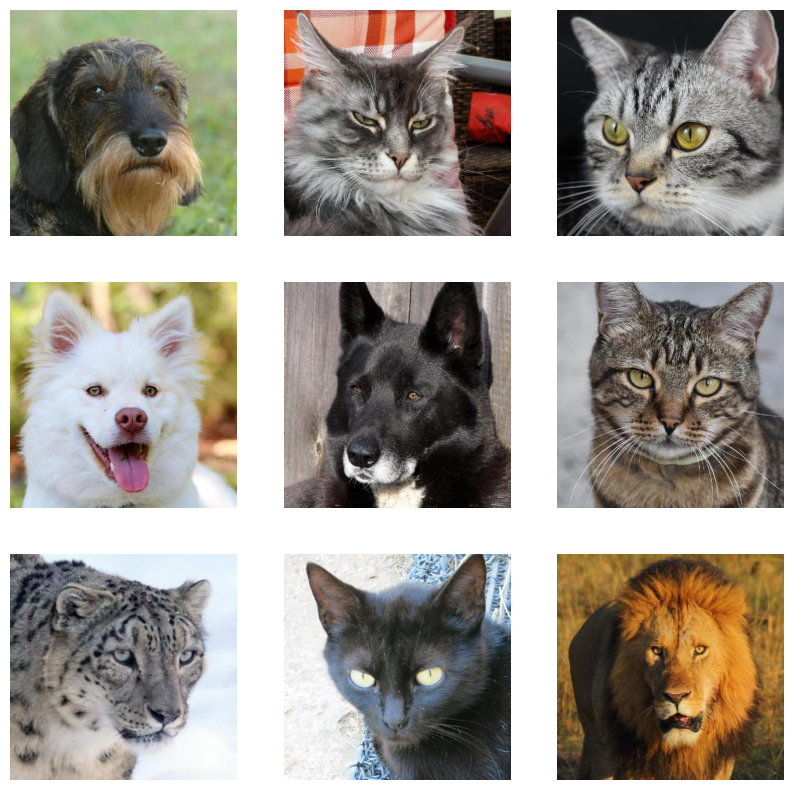

In [11]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10,10))
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

In [12]:
train_dataset.__len__()

11291

In [13]:
train_dataset.__getitem__(2)

(tensor([[[0.8431, 0.8431, 0.8431,  ..., 0.8588, 0.8588, 0.8588],
          [0.8510, 0.8510, 0.8471,  ..., 0.8588, 0.8588, 0.8588],
          [0.8510, 0.8549, 0.8549,  ..., 0.8549, 0.8627, 0.8627],
          ...,
          [0.7647, 0.7569, 0.7373,  ..., 0.9255, 0.9294, 0.9333],
          [0.7647, 0.7529, 0.7412,  ..., 0.9294, 0.9333, 0.9333],
          [0.7725, 0.7490, 0.7412,  ..., 0.9294, 0.9333, 0.9333]],
 
         [[0.8431, 0.8431, 0.8431,  ..., 0.8588, 0.8588, 0.8588],
          [0.8510, 0.8510, 0.8471,  ..., 0.8588, 0.8588, 0.8588],
          [0.8510, 0.8549, 0.8549,  ..., 0.8549, 0.8627, 0.8627],
          ...,
          [0.7608, 0.7529, 0.7333,  ..., 0.9216, 0.9255, 0.9294],
          [0.7608, 0.7490, 0.7373,  ..., 0.9255, 0.9294, 0.9294],
          [0.7686, 0.7451, 0.7373,  ..., 0.9255, 0.9294, 0.9294]],
 
         [[0.8431, 0.8431, 0.8431,  ..., 0.8588, 0.8588, 0.8588],
          [0.8510, 0.8510, 0.8471,  ..., 0.8588, 0.8588, 0.8588],
          [0.8510, 0.8549, 0.8549,  ...,

In [14]:
label_encoder.inverse_transform([2])

array(['wild'], dtype=object)

## Setting hyperparameters

In [15]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Building the Model
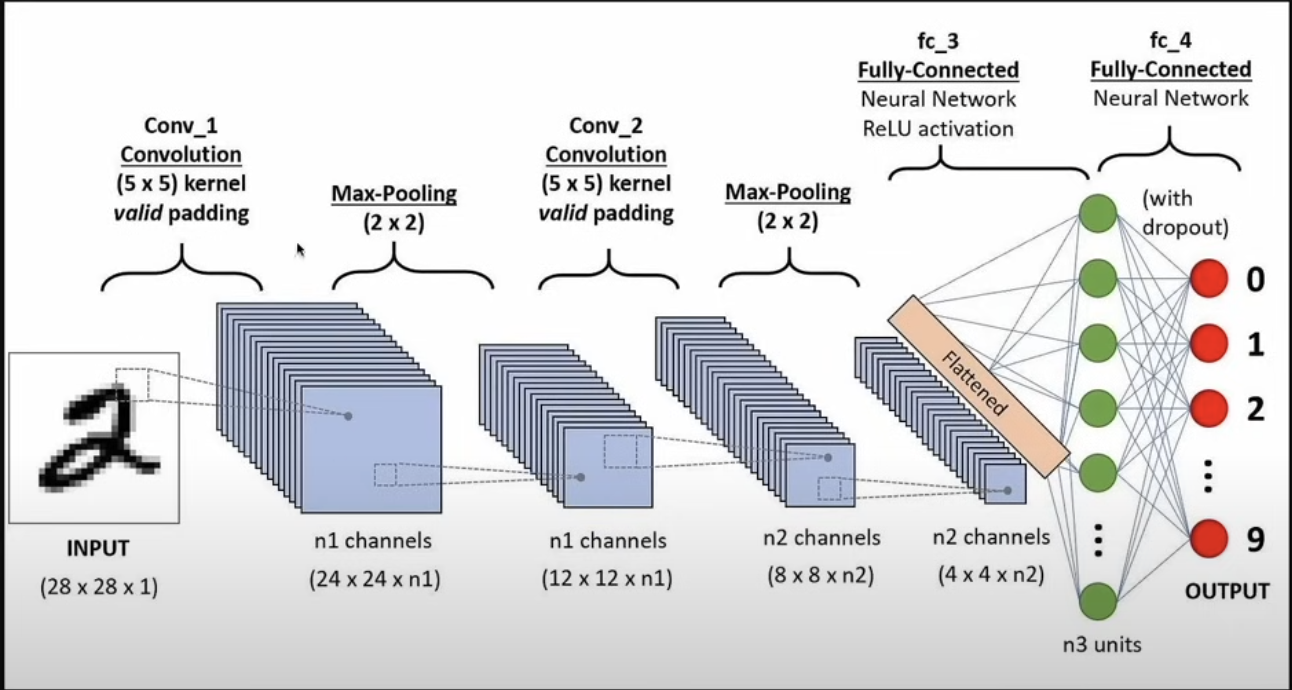

In [17]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()

    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)          # [3,128,128] → [32,128,128]
    x = self.pooling(x)        # [32,128,128] → [32,64,64]
    x = self.relu(x)

    x = self.conv2(x)          # [32,64,64] → [64,64,64]
    x = self.pooling(x)        # [64,64,64] → [64,32,32]
    x = self.relu(x)

    x = self.conv3(x)          # [64,32,32] → [128,32,32]
    x = self.pooling(x)        # [128,32,32] → [128,16,16]
    x = self.relu(x)

    x = self.flatten(x)        # [128,16,16] → [32768]
    x = self.linear(x)         # [32768] → [128]
    x = self.output(x)         # [128] → [num_classes]
    return x


In [18]:
model = Net().to(device)

In [19]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

## Defining loss and optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [24]:
# Storing the epochs
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Starting training loos
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad() #resetting the optimizer

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    #calculating the error between the network's output and the desired output
    train_loss.backward()
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

    print((torch.argmax(outputs, axis=1) == labels))
    print((torch.argmax(outputs, axis=1) == labels).sum().item())
    break
  break


tensor([False,  True,  True, False, False,  True,  True,  True, False, False,
        False, False, False, False, False, False], device='cuda:0')
5


In [25]:
# Storing the epochs
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Starting training loos
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad() #resetting the optimizer

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    #calculating the error between the network's output and the desired output
    train_loss.backward()
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)

      total_loss_val += val_loss.item()
      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round((total_acc_train/ train_dataset.__len__()) * 100 ,4))
  total_acc_validation_plot.append(round((total_acc_val/ val_dataset.__len__()) * 100 ,4))

  print(f'''Eoch: {epoch+1}/{EPOCHS},
        Training Loss: {round(total_loss_train/1000,4)}
        Training Accuracy: {round((total_acc_train/ train_dataset.__len__()) * 100 ,4)}
        Validation Loss: {round(total_loss_val/1000,4)}
        Validation Accuracy: {round((total_acc_val/ val_dataset.__len__()) * 100 ,4)}
        ''')



Eoch: 1/10,
        Training Loss: 0.3169
        Training Accuracy: 81.8528
        Validation Loss: 0.0365
        Validation Accuracy: 92.7273
        
Eoch: 2/10,
        Training Loss: 0.14
        Training Accuracy: 92.7996
        Validation Loss: 0.0296
        Validation Accuracy: 92.9752
        
Eoch: 3/10,
        Training Loss: 0.0934
        Training Accuracy: 95.1997
        Validation Loss: 0.0185
        Validation Accuracy: 96.0331
        
Eoch: 4/10,
        Training Loss: 0.0651
        Training Accuracy: 96.7851
        Validation Loss: 0.019
        Validation Accuracy: 95.7025
        
Eoch: 5/10,
        Training Loss: 0.0463
        Training Accuracy: 97.7681
        Validation Loss: 0.0177
        Validation Accuracy: 95.9091
        
Eoch: 6/10,
        Training Loss: 0.0319
        Training Accuracy: 98.5652
        Validation Loss: 0.0186
        Validation Accuracy: 95.8264
        
Eoch: 7/10,
        Training Loss: 0.0269
        Training Accuracy: 98.6

In [29]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f'''Accuracy Score is : {round((total_acc_test/ test_dataset.__len__()) * 100 ,4)}
        Loss Score is : {round(total_loss_test/1000,4)}
        ''')



Accuracy Score is : 96.1554
        Loss Score is : 0.0175
        


## Plotting

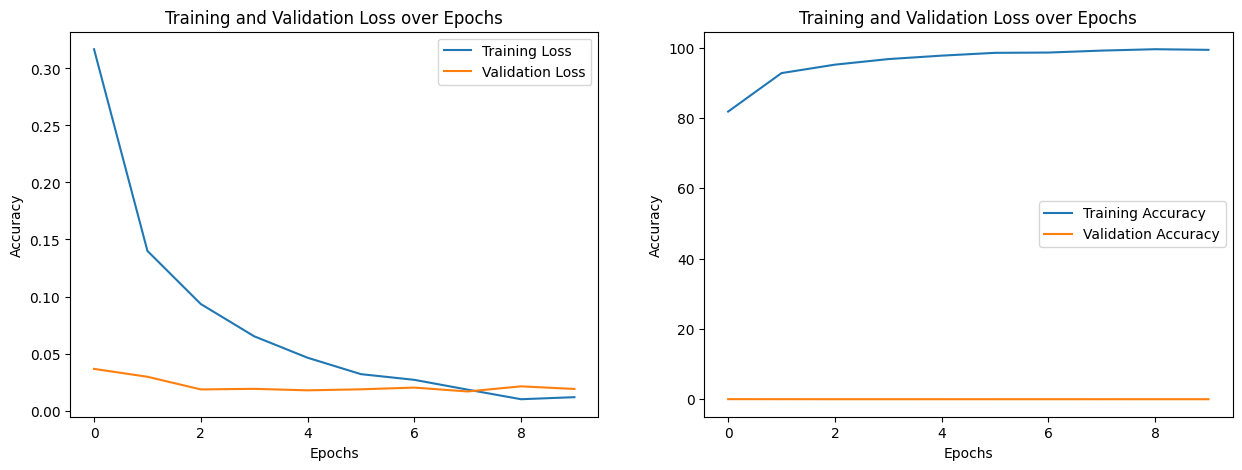

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_loss_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

axs[1].legend()
plt.show()

## Testing on new image

In [47]:
# 1 Read Image
# 2 Transform using transform object
# 3 Predict through the model
# 4 Inverse transfrom by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  # print(image.unsqueeze(0).shape)

  # print(image.shape)

  output = model(image.unsqueeze(0))
  print(output)
  output = torch.argmax(output, axis=1).item()
  return label_encoder.inverse_transform([output])

In [49]:
predict_image("/content/8bdd31fc84a0ad96b5ad21e6ff0c2460.jpg")

tensor([[-2.9428, -1.8778,  4.4341]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['wild'], dtype=object)